<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:200%;
           font-family:Arial;letter-spacing:0.5px">

<p width = 20%, style="padding: 10px;
              color:white;">
Natural Language Processing: Topic Modeling with NMF
              
</p>
</div>

Data Science Cohort Live NYC July 2022
<p>Phase 4: Topic 39</p>
<br>
<br>

<div align = "right">
<img src="Images/flatiron-school-logo.png" align = "right" width="200"/>
</div>
    
    

In [29]:
# standard packages for data analysis and NLP

import numpy as np
import pandas as pd
from copy import deepcopy

#visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

# NLP modules we will use for text normalization
import re #regex 
import nltk # the natural language toolkit
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag

# feature construction
from sklearn.feature_extraction.text import TfidfVectorizer #use this to create BoW matrix

**Some special packages**

In [4]:
!pip install pyLDAvis
#conda install -c conda-forge pyldavis


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136882 sha256=b67420a9cdba61ca84294ee9a21ee0a2a6a080823069894b5b15c9d0fb504e5e
  Stored in directory: c:\users\harri\appdata\local\pip\cache\wheels\57\a4\86\d10c6c2e0bf149fbc0afb0aa5a6528ac35b30a133a0270c477
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=fb6167d485b30bc258e81a3002d6e222dc3fc24f2e9b8f0a8c25aa92e98f3346
  Stored in directory: c:\users\harri\appdata\local\pip\cache\wheels\e4\7b\98\b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Successfully

In [30]:
import pyLDAvis.sklearn # a specialized package for topic model visualization

#modeling and dimensionality reduction for visuaization
from sklearn.decomposition import NMF 
from sklearn.manifold import TSNE # T-distributed Stochastic Neighbor Embedding

#### Taking a look at our data

Load in our Covid-19 Tweet dataset. 
- In general: twitter REST API or tweepy to download tweets.
- We will load from csv.

In [31]:
cvid_dataset_orig = pd.read_csv("Data/Corona_NLP_train.csv", encoding='latin-1')
cvid_dataset_orig = cvid_dataset_orig.rename(columns = {'UserName': 'user_name', 'ScreenName': 'screen_name', 'Sentiment': 'sentiment', 'OriginalTweet': 'text', 'TweetAt': 'date', 'Location': 'location'})

In [32]:
cvid_dataset = deepcopy(cvid_dataset_orig).drop(columns = ['sentiment'])
cvid_dataset.head()

,user_name,screen_name,location,date,text
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV..."


There are no nulls in the  actual text data.

In [33]:
cvid_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_name    41157 non-null  int64 
 1   screen_name  41157 non-null  int64 
 2   location     32567 non-null  object
 3   date         41157 non-null  object
 4   text         41157 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.6+ MB


Let's take a closer look at some of our text data:

In [34]:
cvid_dataset['text'].loc[0]

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

In [35]:
cvid_dataset['text'].loc[15]

'Lines at the grocery store have been unpredictable, but is eating out a safe alternative? \r\r\n\r\r\nFind out more about whether you should be avoiding restaurants right now:  https://t.co/9idZSis5oQ\r\r\n\r\r\n#coronavirus #covid19 https://t.co/ZHbh898lf6'

In [36]:
cvid_dataset['text'].loc[239]

'Please read this thread'

In [37]:
cvid_dataset['text'].loc[2300]

'Want to keep your house clean You only need to spend  5 at your supermarket for just 3 cleaning products here s a video link if you want to know more'

What are some potential cleaning tasks that you can identify?

#### Preprocess tweet text data

Will be our workhorse function for text cleaning and preprocesses a single tweet. 

- Regex: removes hashtags, mentions, urls, line break special characters, etc.

In [38]:
# additional argument sets cut off minimum length for tokenized text at which function converts to null string.
def process_tweet(tweet_text, min_length):
    
    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    tweet_lower = tweet_text.lower()

    #remove mentions, hashtags, and urls, strip whitspace and breaks
    tweet_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", tweet_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
    
    # remove stop words and punctuations 
    tweet_norm = [x for x in word_tokenize(tweet_lower) if ((x.isalpha()) & (x not in stop_words)) ]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(tweet_norm))) 

    # now we are going to have a cutoff here. any tokenized cocument with length < min length will be removed from corpus
    if len(wordnet_tagged) <= min_length:
        return ''
    else:
         # rejoins lemmatized sentence 
         tweet_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
         return tweet_norm



Apply our text normalization and delete empty tweets. Might take a minute or two.

In [40]:
import nltk

# anything with no of tokens <= 10 is likely junk. apply has additional args parameter to pass in function arguments.
cvid_dataset['text'] = cvid_dataset['text'].apply(process_tweet, args = [10])

#our processing created some empty documents, so we should drop these.


In [41]:
# some documents are short enough cleaning may have wiped it out.
cvid_dataset_new = cvid_dataset[cvid_dataset['text'] != '']

#### Creating our Bag of Words Term-Document Matrix

Apply tf-idf vectorizer to transform the preprocessed text into a term-document matrix. 
$$ w_{ij} = tf_{ij}\log(\frac{N}{df_i}) $$

In [42]:
corpus = cvid_dataset_new['text']
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(corpus)
X_train

<29168x25786 sparse matrix of type '<class 'numpy.float64'>'
	with 476907 stored elements in Compressed Sparse Row format>

X_train is in sparse matrix format (saves space/time), can't view directly. 

- Number of unique tokens in our term frequency matrix:

In [43]:
len(vectorizer.get_feature_names())

C:\Users\harri\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


25786

#### Topic Modeling

Once the data is in the right form, scikit learn makes NMF topic modeling is as easy as this:
- fit with 5 topics

In [44]:
topic_model = NMF(n_components = 5)
topic_model.fit(X_train)

C:\Users\harri\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(n_components=5)

Remember that: $$ X = WH $$

Our model has fitted W and H, so we can get these components independently.
- $ W $ encodes the importance of each token in the fitted topics. 
- $ H $ encodes the weight of the fitted topics for each document. 

In [45]:
# to get H
H = topic_model.transform(X_train) # transform document into topic vector representation

# to get W 
W = topic_model.components_ # word component weights for each topic

print("Shape of H is " + str(H.shape))
print("Shape of W is " + str(W.shape))
print("Shape of X_train is " + str(X_train.shape))

Shape of H is (29168, 5)
Shape of W is (5, 25786)
Shape of X_train is (29168, 25786)


- Remember that there are 29,178 tweets in our dataset. 
- Vectorizer created 25,788 features with varying importance. 


**Dimensions and our interpretations of W and H make sense.** 


#### The W matrix

Let's take a look at the tokens (columns of W) with highest weight for each topic (columns) in W:

In [46]:
# weight for given token
print(W[0])
print(len(W[0]))

[0.00048331 0.         0.00021016 ... 0.         0.00019965 0.00100567]
25786


In [47]:
for index,topic in enumerate(W):
    print(f'THE TOP 25 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 25 WORDS FOR TOPIC #0


C:\Users\harri\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['open', 'still', 'home', 'front', 'close', 'say', 'driver', 'risk', 'amp', 'staff', 'keep', 'essential', 'time', 'day', 'retail', 'line', 'people', 'thank', 'get', 'employee', 'work', 'go', 'worker', 'grocery', 'store']


THE TOP 25 WORDS FOR TOPIC #1
['supply', 'see', 'take', 'report', 'fall', 'high', 'company', 'business', 'coronavirus', 'drop', 'gas', 'global', 'crisis', 'covid', 'impact', 'increase', 'due', 'demand', 'market', 'low', 'pandemic', 'amp', 'consumer', 'oil', 'price']


THE TOP 25 WORDS FOR TOPIC #2
['time', 'say', 'amp', 'paper', 'enough', 'help', 'think', 'toilet', 'please', 'empty', 'bank', 'demand', 'stop', 'shelf', 'supply', 'get', 'go', 'buying', 'stock', 'buy', 'need', 'supermarket', 'people', 'panic', 'food']


THE TOP 25 WORDS FOR TOPIC #3
['fight', 'sell', 'virus', 'touch', 'clean', 'sanitizers', 'safe', 'stay', 'bottle', 'wipe', 'water', 'amp', 'wear', 'alcohol', 'glove', 'face', 'soap', 'toilet', 'make', 'paper', 'use', 'wash', 'mask', 'sanitizer', 'hand']


It's often helpful to make a bar visualization of the most relevant token weights for each topic.

In [48]:
%%capture topic_word_plot
def plot_top_words(W, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 8), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20
tfidf_feature_names = vectorizer.get_feature_names()
plot_top_words(W, tfidf_feature_names, n_top_words, "Topics in NMF model")

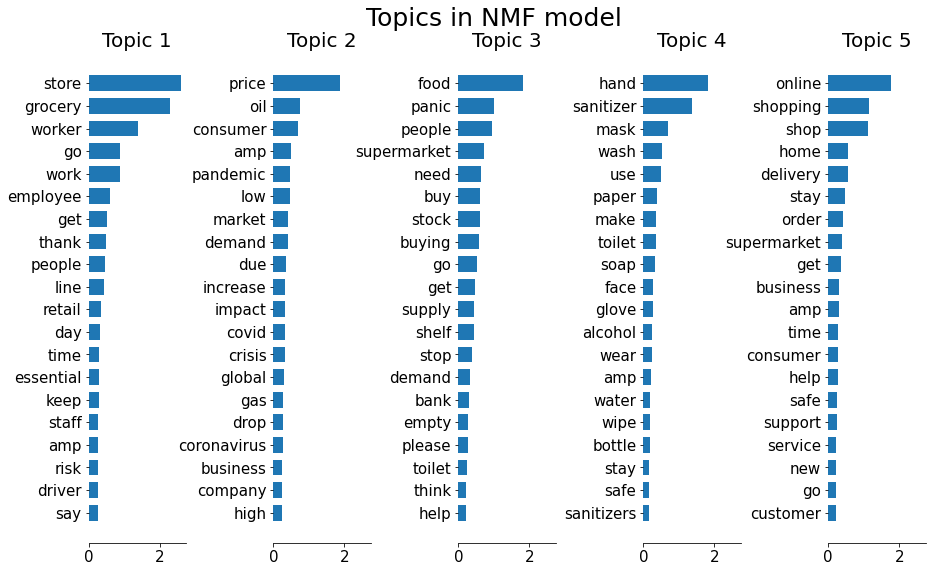

In [49]:
topic_word_plot()

#### PyLDAvis: an excellent tool for visualizing topic models

In [50]:
vis = pyLDAvis.sklearn.prepare(topic_model, X_train, vectorizer)
pyLDAvis.display(vis)
pyLDAvis.save_html(vis, 'nmf_topics.html')

C:\Users\harri\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\harri\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\harri\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
C:\Users\harri\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


Based off of this, let's label these topics with names:

In [53]:
topic_name_dict = {0: 'essential_worker', 1: 'oil_market_crisis', 2: 'supply_shortage', 3: 'sanitizing_products', 4: 'shopping'}

#### The H matrix

So far: word distributions in each topic and evaluated topic similarity/difference. 
- This was all in the matrix $W$. 

But what about $H$? 
- $H$ contains information about breakdowns of topics in each document. Let's see this in action.

In [51]:
# takes in list of documents and plots topic weight vectors for each document
def tweet_topbreakdown(locator):

    print(cvid_dataset_orig.loc[locator].text)
    int_index = cvid_dataset_new.index.get_loc(locator)

    topic_keys = topic_name_dict.values()
    zipped_tuple = list(zip(topic_keys, list(H[int_index,:])))

    topic_breakdown = pd.DataFrame(zipped_tuple, columns = ['Topic', 'Weight']).set_index(['Topic'])
    topic_breakdown['Normalized weight'] = topic_breakdown['Weight']/topic_breakdown['Weight'].sum()

    sns.barplot(y = topic_breakdown.index, x = 'Normalized weight', data = topic_breakdown)
    plt.title("Distribution of topics for tweet no. " + str(locator))
    plt.show()

    return topic_breakdown
    

As news of the regionÂs first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports https://t.co/cfXch7a2lU


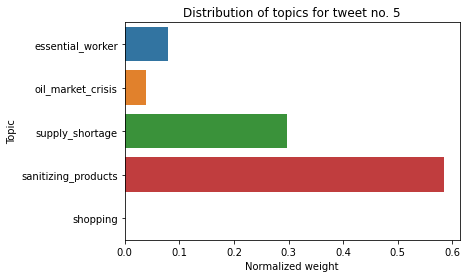

All month there hasn't been crowding in the supermarkets or restaurants, however reducing all the hours and closing the malls means everyone is now using the same entrance and dependent on a single supermarket. #manila #lockdown #covid2019 #Philippines https://t.co/HxWs9LAnF9


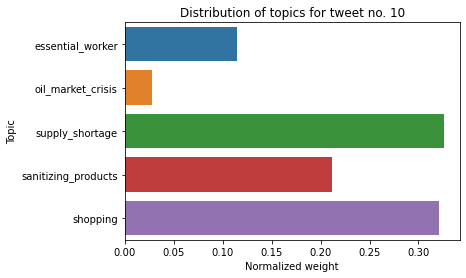



What efforts are your management doing to protect your retail workers?  Speed is crucial here. 


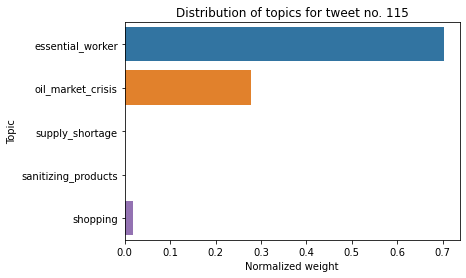

#energytwitter Any takes on the impact of (1) oil price collapse; &amp; (2) fall in energy use from #Covid_19 on natural gas prices? Should we expect (a) over production and price drop, crushing coal use? or, (b) fall in production, price rise and shift to other fuels for power?


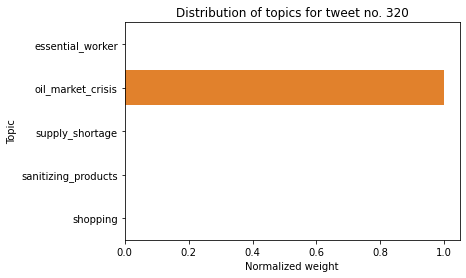

In [54]:
tweet_loc_list = [5,10,115, 320]
g = list(map(tweet_topbreakdown, tweet_loc_list))


### TSNE: A way to visualize our documents by topic in 2D

TSNE (or t-distributed stochastic neighbor embedding) is a way to take high dimensional data and embed it into 2D for visualization. The technique is good at helping to identify clusters or neighborhoods in text data. 

Scale/distances dont mean too much, but clustering and closeness does.

Stochastic because each time you run you get different 2D embeddings.

Scikit-learn makes it easy, only has a fit_transform method.

In [56]:
from sklearn.manifold import TSNE

In [57]:
tsne = TSNE(random_state=42, learning_rate=100)
tsne_trans = tsne.fit_transform(H)
tsne_trans = pd.DataFrame(tsne_trans, columns = ['TSNE1', 'TSNE2'])

C:\Users\harri\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [58]:
# for each document takes the topic with highest weight and assigns document to this class -- hard clustering.
tsne_trans['class'] = np.argmax(H, axis = 1)
tsne_trans['class'] = tsne_trans['class'].replace(topic_name_dict)

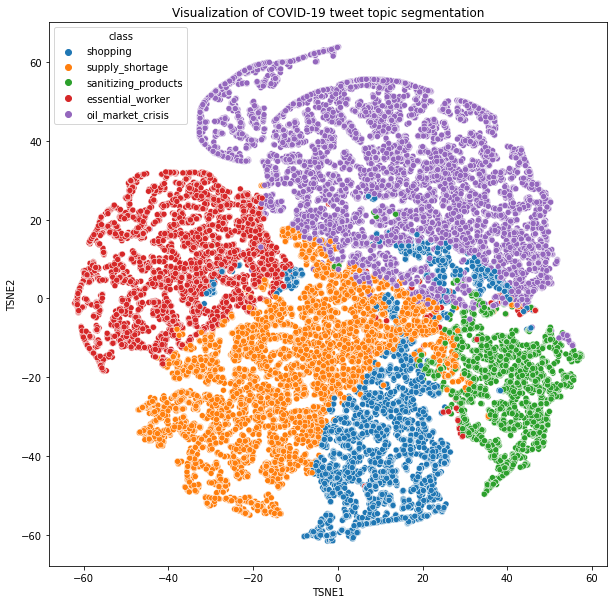

In [59]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = 'TSNE1', y = 'TSNE2', hue = 'class', data = tsne_trans, palette = 'tab10')
plt.title('Visualization of COVID-19 tweet topic segmentation')
plt.show()

#### Finishing up and next steps

We have found a higher level representation of the data, encoded in $H$:

- The algorithm has learned concepts and now we want to do analytics on these concepts.

First, let's reform the data.

In [60]:
H_repres_norm = pd.DataFrame(H, columns = topic_name_dict.values(), index = cvid_dataset_new.index)
H_repres_norm = H_repres_norm.divide(H_repres_norm.sum(axis=1), axis=0)

In [61]:
H_repres_norm.head()

,essential_worker,oil_market_crisis,supply_shortage,sanitizing_products,shopping
1,0.000000,0.004350,0.033110,0.000000,0.962540
2,0.036980,0.132487,0.000000,0.000000,0.830533
3,0.000000,0.000000,0.873143,0.040340,0.086517
4,0.000000,0.000000,1.000000,0.000000,0.000000
5,0.079711,0.039079,0.296867,0.584344,0.000000


Let's join this to the rest of the dataset and clean up a little bit.

In [62]:
embedded_tweets_df = cvid_dataset.join(H_repres_norm).dropna()
embedded_tweets_df.head()

,user_name,screen_name,location,date,text,essential_worker,oil_market_crisis,supply_shortage,sanitizing_products,shopping
1,3800,48752,UK,16-03-2020,advice talk family exchange phone number creat...,0.000000,0.004350,0.033110,0.000000,0.962540
2,3801,48753,Vagabonds,16-03-2020,coronavirus australia woolworths give elderly ...,0.036980,0.132487,0.000000,0.000000,0.830533
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,news first confirm case come sullivan county l...,0.079711,0.039079,0.296867,0.584344,0.000000
6,3805,48757,"35.926541,-78.753267",16-03-2020,cashier grocery store share insight prove cred...,0.923300,0.076700,0.000000,0.000000,0.000000
8,3807,48759,"Atlanta, GA USA",16-03-2020,due retail store classroom open business class...,0.253315,0.148331,0.000000,0.000000,0.598354


In [63]:
embedded_tweets_df.to_csv('cvid_embedded_train.csv')

What kind of tasks could we do or things could we learn from the data in this representation?